In [1]:
# ! pip install -i https://test.pypi.org/simple/ nonholonomics
from nonholonomics import *

In this example I will demonstrate the programs ability to find an equation of motion followed by the state space substitution.After the symbolic work is done I will show that the code can numerically solve the system of ODEs and plot the results.

To validate the accuaracy of my code, I will plot the analytical solution together with the numerical solution. If the there is a noticable difference I will show the error with a few calculations.

## 2-Degrees-of-Freedom Model

In this project we aim to model a system of springs and masses with two degrees of freedom.  The model consists of two blocks with masses, $m_1$ and $m_2$ and spring stiffness k. The first block having mass $m_1$, has displacment $x_1$ and the second block having mass $m_2$ has postion $x_2$. The blocks are free to slide on a frictionless horizontal surface. There is a spring, with stiffness k, attached on the left to a rigid vertical wall and on the right to block one. A second spring equal in stiffness is attached to the other side of block one on the left and to block two on the right. Block two does not have a spring on the right side. If we analyze the energies in the system we can write equations for the potential and kinetic energies leading to a formulation of the lagrangian. The Lagrangian can be written as, 

$$ L=\dfrac{1}{2}(m_1\dot{x}_1^2+m_2\dot{x}_2^2)-\dfrac{1}{2}k(x_1-x_2)^2-\dfrac{1}{2}kx_1^2 $$

We will use this Lagrangian to instantiate a class and evaluate Lagrange's equations,

$$\frac{d}{dt}\left( \frac{\partial L}{\partial \dot{q}_k}\right) − \frac{\partial L}{\partial q_k} = 0$$ 

 to obtain the equations of motion. Where L is the Lagrangian, T is the total kinetic energy and V is the total potential energy. Anticipating the outcome, we can expect two second order ODEs, one for $x_1$ and one for $x_2$. Knowing this, we can then prepare to use a numerical solver by setting up state variables in the form shown below,

$$ z_1 = x_1\;\;\;\;\;\;\;\;\;\;\;\;\;z_2 = x_2$$
$$ z_3 = \dot{x}_1\;\;\;\;\;\;\;\;\;\;\;\;\;z_4 = \dot{x}_2$$

With the system represented as four first order equations we can now use a numerical integrator to obtain the position and velocity of each mass. With this information we can plot the phase portraits, Poincaré sections, or standard positions vs time plots. To ensure the presentation is accesible to the entire audience, advanced topics such as Poincaré sections will not be included.

In [2]:
# The steps below are prerequisites to instatiating the LagrangeEqn class. 
# 
# The coordinates, coordinate derivatives, and parameters need to be made
# into symbols before the Lagrangian can be expressed.

# This step establishes the variable names used for the coordinates used 
# in the lagrangian.
x1,x2=dynamicsymbols('x1 x2')
coordinates=x1,x2

# This step establishes the variable names we wish to use for the state 
# space 
z1,z2,z3,z4=dynamicsymbols('z1 z2 z3 z4')
state_variables=[z1,z2,z3,z4]

# This step assigns variable names fot coordinate derivatives 
x1d,x2d=dynamicsymbols('x1 x2',1)
coordinate_derivatives=x1d,x2d

# This step makes the parameters into symbols.
m1,m2,k=sym.symbols('m1 m2 k')

# The Lagrangian with parameters, coordinates, and coordinate derivatives 
# as symbols and symbol functions.
lagrangian = sym.Rational(1/2)*(m1*x1d**2+m2*x2d**2)-sym.Rational(
            1/2)*(k*(x1-x2)**2)-sym.Rational(1/2)*(k*(x1)**2)

In [3]:
# Instantiation of LagrangeEqn.
system=NHL_Eqn(lagrangian,coordinates,coordinate_derivatives,
                    state_variables,)

# Application of lagranges_equations to obtain equations of motion.
equations_of_motion=system.nh_lagranges_equations()

# Simplification of equaitons of motion for a cleaner, more intuitive 
# looking expression.

equation_of_motion_in_x1=equations_of_motion[0].simplify()
equation_of_motion_in_x2=equations_of_motion[1].simplify();

In [4]:
equation_of_motion_in_x1

2*k*x1(t) - k*x2(t) + m1*Derivative(x1(t), (t, 2))

In [5]:
equation_of_motion_in_x2

-k*(x1(t) - x2(t)) + m2*Derivative(x2(t), (t, 2))

## __Define State Variables__
<a id=2b></a>

In this section we use the make_states method found in the LagrangeEqn class to reduce the system of $2^{nd}$ order ODEs to a system of $1^{st}$ order ODEs. The details of this are exlained more explicitly in the forward and the class definition itself. It is important to display the eqations in state variable form so that we can manually enter the quations into the integrator. Currently, this is the only way I have found to do this. Please note that the indext attached to the equation variable does not correspond to the index of the state on the left hand side. for example, $e_1$ is not used for $z_1$. The equation index is simply the order of the equations in the list.

In [6]:
# Application of make_states method.
e1,e2,e3,e4=system.make_states()

In [7]:
e1

Eq(Derivative(z3(t), t), k*(-2*z1(t) + z2(t))/m1)

In [8]:
e2

Eq(Derivative(z1(t), t), z3(t))

In [9]:
e3

Eq(Derivative(z4(t), t), k*(z1(t) - z2(t))/m2)

In [10]:
e4

Eq(Derivative(z2(t), t), z4(t))

In [11]:
# The following function needs to be altered by the user directly to 
# match the output of the state_space method.
def derivatives(z,time,parameters):

    # These parameters need to match the those listed above in the 
    # prerequisite work.
    m1,m2,k=parameters

    # Here, z represents the state variables. This needs to be manually 
    # altered to fit the model defined by the user.
    z1,z2,z3,z4=z

    # Here is the system of 1st order ODEs that is output from the 
    # state_space method. This needs to be typed in by the user.
    dz1dt = z3
    dz2dt = z4
    dz3dt = (k/m1)*(z2-2*z1)
    dz4dt = (k/m2)*(z1-z2)

    # The return needs to match the number of state variables in the 
    # system.
    #  
    # As a check, this number should be two times the degrees of freedom 
    # for holonomic systems. 
    # 
    # As a reminder this code was built for holonomic systems.
    return dz1dt,dz2dt,dz3dt,dz4dt

# no changes need to be made after this point in this cell.

In [12]:
def numerical_solution(*,parameters:np.ndarray,
                        initial_conditions:np.ndarray,time:np.ndarray):
    '''
    This function takes in the parameters, initial conditions and time.
    
    All inputs must be of the type numpy.ndarray and all inputs to the 
    
    function must be input as keywords.
    
    This function uses odeint from scipy.integrate to compute a numerical 
    
    solution to the Monod type model.

    Parameters
    ----------
    Make a numpy.ndarray that holds the values of the parameters.

    parameters must appear in the array as follows for the example 
    
    presented:

    parameters=numpy.array([m1,m2,k])

    Initial Conditions
    ------------------
    Make a numpy.ndarray for the initial conditions.

    the initial conditions must appear in the array in the following 
    order for the example presented:

    initial_conditions=numpy.array([z1,z2,z3,z4])

    Time
    ----
    Make a numpy.ndarray containing the time space. This array can be 
    either a numpy.arange or a numpy.linspace

    The time vector must progress faster than the dynamics. If the 
    dynamics are happening faster than the time

    decrease the time step.

    '''

    if not type(parameters) is np.ndarray:
        raise TypeError("parameters must be of type numpy.ndarray")
    
    if not type(initial_conditions) is np.ndarray:
        raise TypeError(
            "Initial conditions must be of type numpy.ndarray")
    
    if not type(time) is np.ndarray:
        raise TypeError("Time must be of type numpy.ndarray")


    solution=odeint(derivatives,initial_conditions,
                    time,args=(parameters,))
    
    return solution

### __Plotting__

This section contains various plots in which the behaviour of the system can be examined. As an example, I have provided a five plots. Each plot provides different insight into the system characteristics. 

The first plot shows the displacement of each mass on the same plot. This allows us to look at the response of one compared to the other. For Example, we can see that one amplitude may be higher, one curve may be more purely sinusoidal opposed to having some other periodic motion that loosly resembles a sinusoid. In the our example we can see that both displacements show that they are not a simple sine wave. We should expect this as the exact solution is a linear combination of cosines. Below is the exact solution whe $m_1=m_2=100$ and $k=2000$,

$$\vec{x}(t)=\begin{pmatrix}0.138197 \\0.223607\end{pmatrix} cos(2.76393t)+\begin{pmatrix}0.361803 \\-0.223607\end{pmatrix} cos(7.23606t)$$

with the exact solution, although it contains some rounding error, we should be able to confirm the whether or not the programs runs as expected for a simple case such as this. I have plotted the numerical solution in black for both $x_1$ and $x_2$ for eas of reading. I have also made the lines quite thick for the numercal solution. I have then overlaid the exact solution onto the numerical solution. In my opinion this was the easiest way to see them together as the error is extremely small. 



In [13]:
tmax=5
dt=.0001
time= np.arange(0,tmax+dt,dt)

solution=numerical_solution(parameters=np.array([100,100,2000]),
                            initial_conditions=np.array([.5,0,0,0]),
                            time=time)

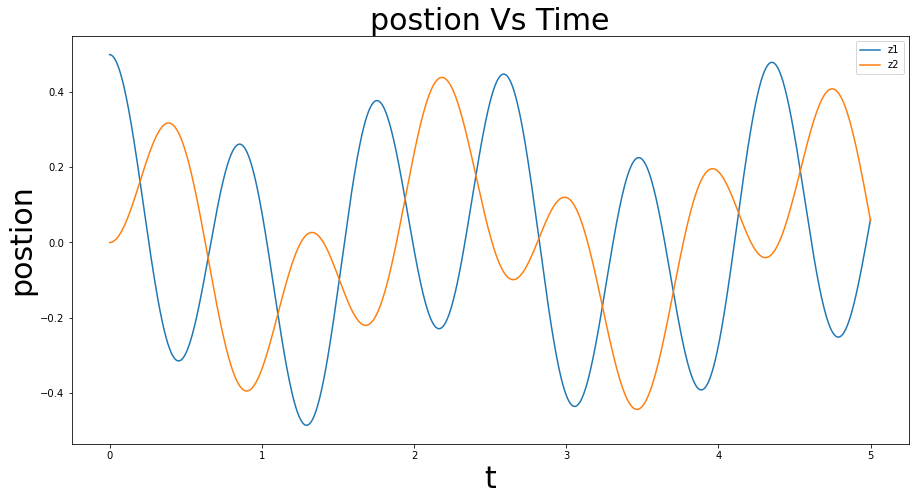

In [14]:
position_solution=np.transpose(np.array([solution[:,0],solution[:,1]]))
plot_n_states(time,kind='postion',solution=position_solution)


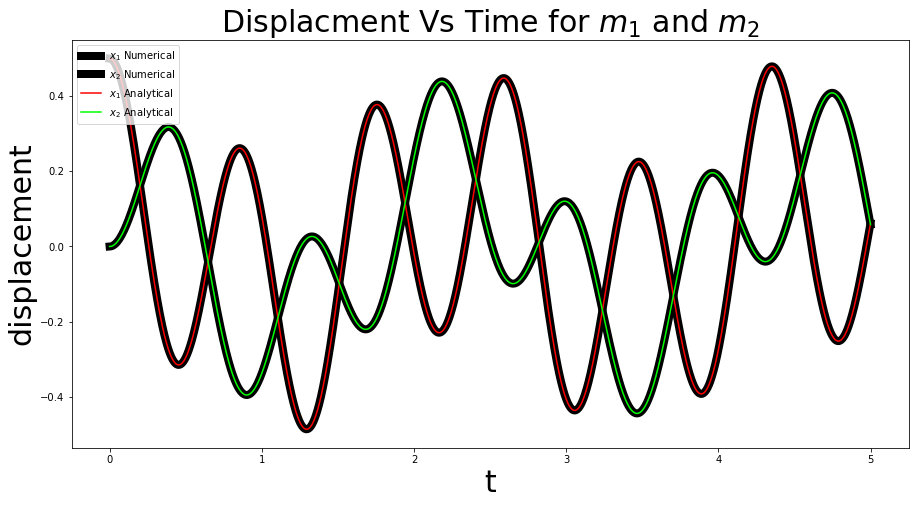

In [15]:
# Analytic Solution
x1a=0.138197*np.cos(2.76393*time)+0.361803*np.cos(7.23606*time)
x2a=0.223607*np.cos(2.76393*time)-0.223607*np.cos(7.23606*time)

plt.figure(figsize=(15,7.5))

plt.plot(time,solution[:,0],label='$x_1$ Numerical',
        linewidth=8,color='black')

plt.plot(time,solution[:,1],label='$x_2$ Numerical',
        linewidth=8,color='black')

plt.plot(time,x1a,label='$x_1$ Analytical',color='red')
plt.plot(time,x2a,label='$x_2$ Analytical',color='lime')

plt.title('Displacment Vs Time for $m_1$ and $m_2$',fontsize=30)
plt.xlabel('t',fontsize=30)
plt.ylabel('displacement',fontsize=30)

plt.legend(fontsize=10,loc='upper left')
plt.show()